In [32]:
import numpy as np
from shapely.geometry.polygon import LinearRing, Polygon
import json
import math
from datetime import datetime
from shapely import box, LineString, normalize, Polygon, Point

In [67]:
def make_circle(radius = 1, shape=1, x0=0, y0=0, nPoints=500):
    theta = np.linspace(0,2*np.pi, nPoints)
    xx = radius * np.sin(theta) + x0
    yy = radius * np.cos(theta) + y0
    segs = []
    for idx, (x, y) in enumerate(zip(xx, yy)):
        if idx<1:
            px, py = x, y
            continue
        seg = (px, py, x, y, shape)
        segs.append(seg)
        px, py = x, y
    return segs
make_square = lambda l, x0=0, y0=0: Polygon([ Point([l*ver[0], l*ver[1]]) for ver in [(-1, -1), (1, -1), (1, 1), (-1, 1)]])
    

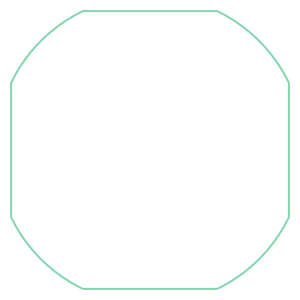

In [68]:
def make_mosfire_fov(l=6.12, r=3.4, shape=1):
    circ = Polygon([Point(seg[0:2]) for seg in make_circle(r * 60 * 2 , 1, 0, 0, 100)])
    square = make_square(l * 60  )
    mf = square.intersection(circ)
    segs = []

    for idx, (x, y) in enumerate(zip(mf.exterior.xy[0], mf.exterior.xy[1])):
        if idx<1:
            px, py = x, y
            continue
        seg = (px, py, x, y, shape)
        segs.append(seg)
        px, py = x, y
    return segs, mf
segs, mf = make_mosfire_fov()
    
strSegs = [" ".join(x)+'\n' for x in [[str(el) for el in seg] for seg in segs]]
mosfireshape = [[seg[0], seg[1]] for seg in segs]
mf.exterior

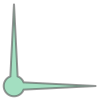

In [82]:
# Generate the compass rose
import shapely.geometry as sg
import matplotlib.pyplot as plt
from shapely.affinity import rotate, scale

def create_compass_rose(center, radius, baseWidthRat=0.1):
    """Creates a Shapely compass rose polygon."""
    x, y = center

    # Create the main circle
    circle = sg.Point(center).buffer(radius/8)
    baseWidth = radius * baseWidthRat

    # Create the N, S, E, W arms
    north = sg.Polygon([(x - baseWidth/2 , y), (x, y + radius), (x + baseWidth/2, y), (x - baseWidth/2, y)])
    west = rotate(north, 90, center)
    south = rotate(north, 180, center)
    east = rotate(north, 270, center)

    # Create the NE, NW, SE, SW arms
    mag = .707
    ne = rotate( scale(north, mag, mag), -45, center)
    nw = rotate( scale(north, mag, mag), 45, center)
    se = rotate( scale(north, mag, mag), 45+180, center)
    sw = rotate( scale(north, mag, mag), -45+180, center)

    # Combine all the elements
    # compass_rose = circle.union(north).union(south).union(east).union(west).union(ne).union(nw).union(se).union(sw)
    compass_rose = circle.union(north).union(east)

    return compass_rose

# Create the compass rose
compass = create_compass_rose((0, 0), 50)
compasscoords = list(zip(compass.exterior.xy[0], compass.exterior.xy[1]))

# Plot the compass rose
compass

In [ ]:
c1, c2 = make_circle(136, 2, 0, 0, 200), make_circle(65, 3, 0, 0, 200)
segs = [ *c1, *c2]
kcwishape = [ [ [x[0], x[1]] for x in c1 ], [ [ x[0], x[1] ] for x in c2 ] ]

instGeoJSON = { "type": "FeatureCollection",
    "features": [
{ 
  "type": "Feature",
  "properties": {"instrument": "KCWI", "type": "FOV", "units": "arcsec"},
  "geometry": {
    "type": "MultiPolygon",
    "coordinates": 
      kcwishape
    }
},
        { 
  "type": "Feature",
  "properties": {"instrument": "MOSFIRE", "type": "FOV", "units": "pixels"},
  "geometry": {
    "type": "MultiPolygon",
    "coordinates": 
      [mosfireshape]
    }
}
,
        { 
  "type": "Feature",
  "properties": {"name": "CompassRose", "type": "static shape"},
  "geometry": {
    "type": "MultiPolygon",
    "coordinates": 
      [compasscoords]
    }
}
    ]}
with open('FEATURES.json', 'w') as f:
    json.dump(instGeoJSON, f, indent = 2)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support() 
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import math
import astroplan as apl
KECK_LAT = 19.8260 #[deg]
KECK_ELEVATION = 4.1449752 # km
RADIUS_EARTH = 6378.1000 # km
ATMOSPHERE_HEIGHT = 50.000 # km
KECK_LONG = 360 - 155.4747 

def date_to_juld(date):
    return (date.timestamp() / 86400) + 2440587.5 #do not offset
    #return (date.timestamp() / 86400)

def get_gmt(date=None):
    if date is None:
        date = datetime.now()
    JD = date_to_juld(date)
    T = (JD - 2451545) / 36525
    ThetaGMST = 67310.54841 + (876600 * 3600 + 8640184.812866) * T + .093104 * (T**2) - (6.2 * 10**-6) * (T**3)
    ThetaGMST = (ThetaGMST % (86400 * (ThetaGMST / abs(ThetaGMST))) / 240) % 360

    return ThetaGMST

def cosd(deg):
    return math.cos(math.pi / 180 * deg)

def sind(deg):
    return math.sin(math.pi / 180 * deg)

def tand(deg):
    return math.tan(math.pi / 180 * deg)

def ra_dec_to_az_alt(ra, dec, date=None):
    if date is None:
        date = datetime.now()
    lngLatEl = { 'lng': KECK_LONG, 'lat': KECK_LAT, 'ele': KECK_ELEVATION }
    hourAngle = (get_gmt(date) + lngLatEl['lng'] - ra) % 360
    tanAzNum = sind(hourAngle)
    tanAzDen = cosd(hourAngle) * sind(lngLatEl['lat']) - tand(dec) * cosd(lngLatEl['lat'])
    az = math.atan2(tanAzNum, tanAzDen) + math.pi
    sinEl = sind(lngLatEl['lat']) * sind(dec) + cosd(lngLatEl['lat']) * cosd(dec) * cosd(hourAngle)
    el = math.asin(sinEl)
    return [(180 / math.pi * az), (180 / math.pi * el)]

ra = 10.0
dec = 10.0
date = datetime.now()
py_alt_az = ra_dec_to_az_alt(ra, dec, date)

keck = EarthLocation(lat=KECK_LAT*u.deg, lon=KECK_LONG*u.deg, height=KECK_ELEVATION*u.m)
coord = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')

#coord = SkyCoord(ra * u.hourangle, dec * u.deg, frame="icrs")
target = apl.FixedTarget(name='tgt', coord=coord)
time = Time(date +timedelta(hours=10))
ap_alt_az = coord.transform_to(AltAz(obstime=time,location=keck))

keckap = apl.Observer.at_site("W. M. Keck Observatory")
altaz = keckap.altaz(date, target, grid_times_targets=True)
print(date)
print(py_alt_az[1])
print(ap_alt_az.az.value)
print(altaz.az.value)


2024-04-04 08:48:41.510667
41.1313360730198
93.71508772051209
[[324.28348417]]


In [53]:
from random import randrange
from datetime import timedelta
d1 = datetime.strptime('1/1/2008 1:30 PM', '%m/%d/%Y %I:%M %p')
d2 = datetime.strptime('1/1/2039 4:50 AM', '%m/%d/%Y %I:%M %p')


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

data = []
for _ in range(10**2):
    date = random_date(d1, d2)
    ra = np.random.uniform(0, 360)
    dec = np.random.uniform(-90, 90)
    coord = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')
    target = apl.FixedTarget(name='tgt', coord=coord)
    time = Time(date +timedelta(hours=10))
    ap_alt_az = coord.transform_to(AltAz(obstime=time,location=keck))
    py_alt_az = ra_dec_to_az_alt(ra, dec, date)
    datum = {
        'ra': ra, 'dec': dec, 'date': date,
        'ap_az': ap_alt_az.az.value, 'ap_alt': ap_alt_az.alt.value,
        'py_alt': py_alt_az[0], 'py_az': py_alt_az[1],
        'alt_err': py_alt_az[0] - ap_alt_az.alt.value,
        'az_err': py_alt_az[1] - ap_alt_az.az.value,
    }
    # data.append({
    #     'ra': ra, 'dec': dec, 'date': date, 'model': 'astropy',
    #     'az': ap_alt_az.az.value })
    # data.append({
    #     'ra': ra, 'dec': dec, 'date': date, 'model': 'tyler',
    #     'az': py_alt_az[0] })

    data.append(datum)

/home/tyler/anaconda3/envs/firstEnv/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tyler/anaconda3/envs/firstEnv/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tyler/anaconda3/envs/firstEnv/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tyler/anaconda3/envs/firstEnv/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [54]:
data[0]

{'ra': 298.833240003677,
 'dec': -51.232171448000216,
 'date': datetime.datetime(2034, 9, 30, 10, 41, 2),
 'ap_az': 142.69624059007836,
 'ap_alt': -42.97985268057952,
 'py_alt': 142.58123330917988,
 'py_az': -42.566513208624585,
 'alt_err': 185.5610859897594,
 'az_err': -185.26275379870293}

<AxesSubplot: xlabel='az_err', ylabel='Count'>

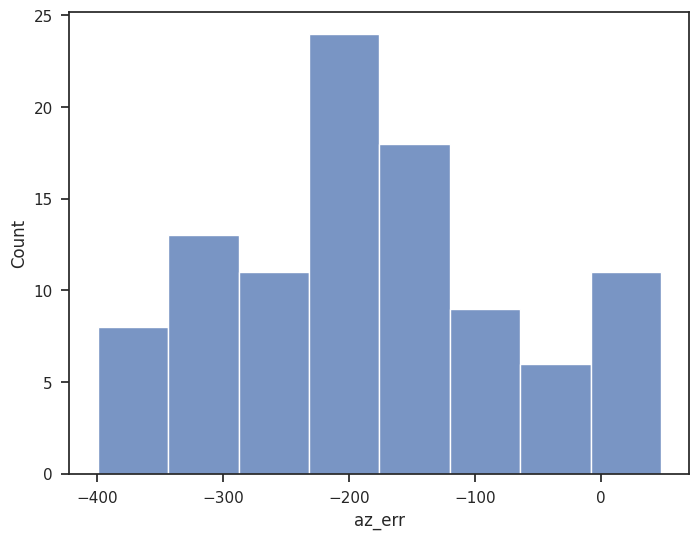

In [56]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="ticks")

#df = sns.load_dataset("penguins")
df = pd.DataFrame(data)
#sns.pairplot(df, hue="az_err")
#sns.boxplot(y='az_err',data=df)
sns.histplot(data=df, x="az_err")

In [2]:
%%timeit
ra_dec_to_az_alt(ra, dec, date)

3.72 µs ± 48.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [3]:
keck = EarthLocation(lat=KECK_LAT*u.deg, lon=KECK_LONG*u.deg, height=KECK_ELEVATION*u.m)

In [4]:
%%timeit
coord.transform_to(AltAz(obstime=Time(date, scale='utc'),location=keck))

UsageError: Line magic function `%%timeit` not found.


In [5]:
keck = apl.Observer.at_site("W. M. Keck Observatory")

In [6]:
%%timeit
altaz = keck.altaz(date, target, grid_times_targets=True)

4.48 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
